In [ ]:
# Crash on purpose to get more ram :
#import torch
#torch.tensor([10.]*10000000000)

Let's install [PyTorch/XLA](https://github.com/pytorch/xla) which enables PyTorch on TPU. Make sure you install the nightly version, as the trainer breaks on other versions.

In [1]:
VERSION = "nightly"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  26159      0 --:--:-- --:--:-- --:--:-- 26159
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
Uninstalling torch-1.6.0a0+3bbedb3:
  Successfully uninstalled torch-1.6.0a0+3bbedb3
Uninstalling torchvision-0.7.0a0+cd2b7f0:
  Successfully uninstalled torchvision-0.7.0a0+cd2b7f0
Copying gs://tpu-pytorch/wheels/torch-nightly-cp36-cp36m-linux_x86_64.whl...
- [1 files][106.7 MiB/106.7 MiB]                                                
Operation completed over 1 objects/106.7 MiB.                                    
Copying gs://tpu-pytorch/wheels/torch_xla-nightly-cp36-cp36m-linux_x86_64.whl...
- [1 files][122.0 MiB/122.0 MiB]                                                
Operation completed over 1 objects/122.0 MiB.                                    


Install transformers and the nlp package. Restart colab after this

In [2]:
!git clone https://github.com/huggingface/transformers.git
!pip install ./transformers


fatal: destination path 'transformers' already exists and is not an empty directory.
Processing ./transformers
  Created wheel for transformers: filename=transformers-2.11.0-cp36-none-any.whl size=734076 sha256=75df6f80ceeeb8712ac57cf4cd350ef0d07f986654a11ebba21048b12d99043c
  Stored in directory: /tmp/pip-ephem-wheel-cache-_rje8isy/wheels/23/19/dd/2561a4e47240cf6b307729d58e56f8077dd0c698f5992216cf
Successfully built transformers
  Found existing installation: transformers 2.11.0
    Uninstalling transformers-2.11.0:
      Successfully uninstalled transformers-2.11.0


## Load and process data

In [3]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from transformers import XLMRobertaTokenizer, XLMRobertaModel
import torch.nn as nn 
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
import json
import pandas as pd

import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

In [4]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"doanquanvietnamca","key":"2bc9ebe82282c4fe649204ee312360d1"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle
!kaggle competitions download -c tweet-sentiment-extraction

  0% 0.00/41.4k [00:00<?, ?B/s]
100% 41.4k/41.4k [00:00<00:00, 39.1MB/s]
  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 93.8MB/s]
  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 83.6MB/s]


In [7]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [8]:
!mkdir data
!mv *.csv data
!mkdir models

In [73]:
import pandas as pd
train = pd.read_csv('data/train.csv')


In [74]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [75]:
train[train['text']=='']

,textID,text,selected_text,sentiment


In [76]:
train['sentiment'].value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [77]:
content = []
for i in range(len(train)):
  content.append("context: %s content: %s </s>"%(train['text'][i], train['sentiment'][i]))
train['content'] = content

In [79]:
def lens(t):
  return len(str(t).split())
train['len'] = train['selected_text'].apply(lens)

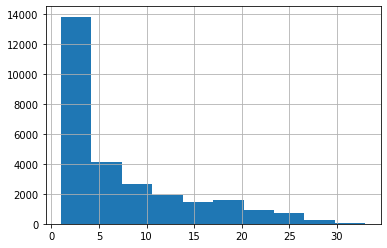

In [80]:
train['len'].hist()

In [81]:
def pre(t):
  return "%s </s>"%t
train['selected_text'] = train['selected_text'].apply(pre)

In [82]:
from sklearn.model_selection import train_test_split
train = train[['content','selected_text']]
train.columns = ['text', 'target']
train, valid = train_test_split(train, test_size=0.2, random_state=42)

In [45]:
from torch.utils.data import *
class ToxicDataset(Dataset):
  def __init__(self, tokenizer, df,  max_len=512):
    self.data_column = df["text"].values
    self.class_column = df['target'].values
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []
    self._build()
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"input_ids": source_ids, "attention_mask": src_mask, "target_ids": target_ids, "target_attention_mask": target_mask}
  
  def _build(self):
    for idx in range(len(self.data_column)):
      input_ =  self.data_column[idx]
      target =  self.class_column[idx]
       # tokenize inputs
      tokenized_inputs = self.tokenizer.encode_plus(
          str(input_), max_length=self.max_len, pad_to_max_length=True,truncation=True, return_tensors="pt"
      )
      tokenized_targets = self.tokenizer.encode_plus(
          str(target), max_length=32, pad_to_max_length=True, truncation=True, return_tensors="pt"
      )
      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)


In [84]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
train_dataset = ToxicDataset(tokenizer, train,128)
valid_dataset = ToxicDataset(tokenizer,valid,128)

In [85]:
%%time
train_dataset[1]

CPU times: user 981 µs, sys: 0 ns, total: 981 µs
Wall time: 614 µs


{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([2625,   10,   25,  225,    5,  738,   10, 7163,    1,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0

In [86]:
len(train_dataset), len(valid_dataset)

(21984, 5497)

In [87]:
# cach the dataset, so we can load it directly for training

torch.save(train_dataset, 'train_data.pt')
torch.save(valid_dataset, 'valid_data.pt')

For more details on how to use the nlp library check out this [notebook](https://colab.research.google.com/github/huggingface/nlp/blob/master/notebooks/Overview.ipynb).

## Write training script

In [5]:
import dataclasses
import logging
import os
import sys
from dataclasses import dataclass, field
from typing import Dict, List, Optional

import numpy as np
import torch

from transformers import T5ForConditionalGeneration, T5Tokenizer, EvalPrediction
from transformers import (
    HfArgumentParser,
    DataCollator,
    Trainer,
    TrainingArguments,
    set_seed,
)


logger = logging.getLogger(__name__)

# prepares lm_labels from target_ids, returns examples with keys as expected by the forward method
# this is necessacry because the trainer directly passes this dict as arguments to the model
# so make sure the keys match the parameter names of the forward method
@dataclass
class T2TDataCollator():
    def collate_batch(self, batch: List) -> Dict[str, torch.Tensor]:
        """
        Take a list of samples from a Dataset and collate them into a batch.
        Returns:
            A dictionary of tensors
        """
        input_ids = torch.stack([example['input_ids'] for example in batch])
        lm_labels = torch.stack([example['target_ids'] for example in batch])
        lm_labels[lm_labels[:, :] == 0] = -100
        attention_mask = torch.stack([example['attention_mask'] for example in batch])
        decoder_attention_mask = torch.stack([example['target_attention_mask'] for example in batch])
        

        return {
            'input_ids': input_ids, 
            'attention_mask': attention_mask,
            'lm_labels': lm_labels, 
            'decoder_attention_mask': decoder_attention_mask
        }


@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
    """

    model_name_or_path: str = field(
        metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default=None, metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
    )

@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    """
    train_file_path: Optional[str] = field(
        default='train_data.pt',
        metadata={"help": "Path for cached train dataset"},
    )
    valid_file_path: Optional[str] = field(
        default='valid_data.pt',
        metadata={"help": "Path for cached valid dataset"},
    )
    max_len: Optional[int] = field(
        default=512,
        metadata={"help": "Max input length for the source text"},
    )
    target_max_len: Optional[int] = field(
        default=32,
        metadata={"help": "Max input length for the target text"},
    )


def main():
    # See all possible arguments in src/transformers/training_args.py
    # or by passing the --help flag to this script.
    # We now keep distinct sets of args, for a cleaner separation of concerns.

    parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))

    # we will load the arguments from a json file, 
    #make sure you save the arguments in at ./args.json
    model_args, data_args, training_args = parser.parse_json_file(json_file=os.path.abspath('args.json'))

    if (
        os.path.exists(training_args.output_dir)
        and os.listdir(training_args.output_dir)
        and training_args.do_train
        and not training_args.overwrite_output_dir
    ):
        raise ValueError(
            f"Output directory ({training_args.output_dir}) already exists and is not empty. Use --overwrite_output_dir to overcome."
        )

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if training_args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        training_args.local_rank,
        training_args.device,
        training_args.n_gpu,
        bool(training_args.local_rank != -1),
        training_args.fp16,
    )
    logger.info("Training/evaluation parameters %s", training_args)

    # Set seed
    set_seed(training_args.seed)

    # Load pretrained model and tokenizer
    #
    # Distributed training:
    # The .from_pretrained methods guarantee that only one local process can concurrently
    # download model & vocab.

    tokenizer = T5Tokenizer.from_pretrained(
        model_args.tokenizer_name if model_args.tokenizer_name else model_args.model_name_or_path,
        cache_dir=model_args.cache_dir,
    )
    model = T5ForConditionalGeneration.from_pretrained(
        model_args.model_name_or_path,
        cache_dir=model_args.cache_dir,
    )

    # Get datasets
    print('loading data')
    train_dataset  = torch.load(data_args.train_file_path)
    valid_dataset = torch.load(data_args.valid_file_path)
    print('loading done')

    # Initialize our Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        data_collator=T2TDataCollator(),
        prediction_loss_only=True
    )

    # Training
    if training_args.do_train:
        trainer.train(
            model_path=model_args.model_name_or_path if os.path.isdir(model_args.model_name_or_path) else None
        )
        trainer.save_model()
        # For convenience, we also re-save the tokenizer to the same directory,
        # so that you can share your model easily on huggingface.co/models =)
        if trainer.is_world_master():
            tokenizer.save_pretrained(training_args.output_dir)

    # Evaluation
    results = {}
    if training_args.do_eval and training_args.local_rank in [-1, 0]:
        logger.info("*** Evaluate ***")

        eval_output = trainer.evaluate()

        output_eval_file = os.path.join(training_args.output_dir, "eval_results.txt")
        with open(output_eval_file, "w") as writer:
            logger.info("***** Eval results *****")
            for key in sorted(eval_output.keys()):
                logger.info("  %s = %s", key, str(eval_output[key]))
                writer.write("%s = %s\n" % (key, str(eval_output[key])))
    
        results.update(eval_output)
    
    return results


def _mp_fn(index):
    # For xla_spawn (TPUs)
    main()

In [6]:
import json
args_dict = {
  "num_cores": 8,
  "model_name_or_path": 't5-base',
  "max_len": 128 ,
  "target_max_len": 2,
  "output_dir": './models/tpu',
  "overwrite_output_dir": True,
  "per_device_train_batch_size": 4,
  "per_gpu_eval_batch_size": 4,
  "gradient_accumulation_steps": 4,
  "learning_rate": 3e-5,
  "tpu_num_cores": 8,
  "num_train_epochs": 16,
  "do_train": True
}
with open('args.json', 'w') as f:
  json.dump(args_dict, f)

In [7]:
import torch_xla.distributed.xla_multiprocessing as xmp


In [8]:
xmp.spawn(_mp_fn, args=(), nprocs=8, start_method='fork')

06/21/2020 18:21:43 - INFO - transformers.training_args -   PyTorch: setting up devices
06/21/2020 18:21:43 - WARNING - __main__ -   Process rank: -1, device: xla:1, n_gpu: 0, distributed training: False, 16-bits training: False
06/21/2020 18:21:43 - INFO - __main__ -   Training/evaluation parameters TrainingArguments(output_dir='./models/tpu', overwrite_output_dir=True, do_train=True, do_eval=False, do_predict=False, evaluate_during_training=False, per_device_train_batch_size=4, per_device_eval_batch_size=8, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=4, gradient_accumulation_steps=4, learning_rate=3e-05, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=16, max_steps=-1, warmup_steps=0, logging_dir='runs/Jun21_18-21-43_e78b803b46ca', logging_first_step=False, logging_steps=500, save_steps=500, save_total_limit=None, no_cuda=False, seed=42, fp16=False, fp16_opt_level='O1', local_rank=-1, tpu_num_cores=8, tpu_metrics_debug=False, dataloader_drop_last=

loading data


06/21/2020 18:21:52 - INFO - transformers.modeling_utils -   Weights of T5ForConditionalGeneration not initialized from pretrained model: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']


loading data


06/21/2020 18:21:52 - INFO - transformers.modeling_utils -   Weights of T5ForConditionalGeneration not initialized from pretrained model: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']


loading data


06/21/2020 18:21:52 - INFO - transformers.modeling_utils -   Weights of T5ForConditionalGeneration not initialized from pretrained model: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']


loading data


06/21/2020 18:21:52 - INFO - transformers.modeling_utils -   Weights of T5ForConditionalGeneration not initialized from pretrained model: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']


loading data


06/21/2020 18:21:53 - INFO - transformers.modeling_utils -   Weights of T5ForConditionalGeneration not initialized from pretrained model: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']


loading data


06/21/2020 18:21:53 - INFO - transformers.modeling_utils -   Weights of T5ForConditionalGeneration not initialized from pretrained model: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']


loading data


06/21/2020 18:21:57 - INFO - transformers.modeling_utils -   Weights of T5ForConditionalGeneration not initialized from pretrained model: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']


loading data
loading done
loading done
loading done
loading done
loading done
loading done
loading done
loading done


06/21/2020 18:22:52 - INFO - transformers.trainer -   You are instantiating a Trainer but W&B is not installed. To use wandb logging, run `pip install wandb; wandb login` see https://docs.wandb.com/huggingface.
/usr/local/lib/python3.6/dist-packages/transformers/trainer.py:216: FutureWarning: The `data_collator` should now be a simple callable (function, class with `__call__`), classes with a `collate_batch` are deprecated and won't be supported in a future version.
  FutureWarning,
06/21/2020 18:22:52 - INFO - transformers.trainer -   ***** Running training *****
06/21/2020 18:22:52 - INFO - transformers.trainer -     Num examples = 21984
06/21/2020 18:22:52 - INFO - transformers.trainer -     Num Epochs = 16
06/21/2020 18:22:52 - INFO - transformers.trainer -     Instantaneous batch size per device = 4
06/21/2020 18:22:52 - INFO - transformers.trainer -     Total train batch size (w. parallel, distributed & accumulation) = 32
06/21/2020 18:22:52 - INFO - transformers.trainer -     Gr

06/21/2020 18:23:07 - INFO - transformers.trainer -   You are instantiating a Trainer but W&B is not installed. To use wandb logging, run `pip install wandb; wandb login` see https://docs.wandb.com/huggingface.
/usr/local/lib/python3.6/dist-packages/transformers/trainer.py:216: FutureWarning: The `data_collator` should now be a simple callable (function, class with `__call__`), classes with a `collate_batch` are deprecated and won't be supported in a future version.
  FutureWarning,
06/21/2020 18:23:07 - INFO - transformers.trainer -   ***** Running training *****
06/21/2020 18:23:07 - INFO - transformers.trainer -     Num examples = 21984
06/21/2020 18:23:07 - INFO - transformers.trainer -     Num Epochs = 16
06/21/2020 18:23:07 - INFO - transformers.trainer -     Instantaneous batch size per device = 4
06/21/2020 18:23:07 - INFO - transformers.trainer -     Total train batch size (w. parallel, distributed & accumulation) = 32
06/21/2020 18:23:07 - INFO - transformers.trainer -     Gr

06/21/2020 18:37:38 - INFO - transformers.trainer -   {'loss': 0.37196933014073874, 'learning_rate': 2.4517543859649125e-05, 'epoch': 2.919941775836972, 'step': 500}
06/21/2020 18:37:38 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu/checkpoint-500
06/21/2020 18:37:38 - INFO - transformers.trainer -   {'loss': 0.3720209414247656, 'learning_rate': 2.4517543859649125e-05, 'epoch': 2.919941775836972, 'step': 500}
06/21/2020 18:37:38 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu/checkpoint-500
06/21/2020 18:37:38 - INFO - transformers.trainer -   {'loss': 0.3625099856063025, 'learning_rate': 2.4517543859649125e-05, 'epoch': 2.919941775836972, 'step': 500}
06/21/2020 18:37:38 - INFO - transformers.trainer -   {'loss': 0.3641289316781331, 'learning_rate': 2.4517543859649125e-05, 'epoch': 2.919941775836972, 'step': 500}
06/21/2020 18:37:38 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu/checkpoint-500
06/21/2020 1

06/21/2020 18:50:07 - INFO - transformers.trainer -   {'loss': 0.25993377027264797, 'learning_rate': 1.903508771929825e-05, 'epoch': 5.844250363901019, 'step': 1000}
06/21/2020 18:50:07 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu/checkpoint-1000
06/21/2020 18:50:07 - INFO - transformers.trainer -   {'loss': 0.26908892912219745, 'learning_rate': 1.903508771929825e-05, 'epoch': 5.844250363901019, 'step': 1000}
06/21/2020 18:50:07 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu/checkpoint-1000
06/21/2020 18:50:07 - INFO - transformers.trainer -   {'loss': 0.26393478135205806, 'learning_rate': 1.903508771929825e-05, 'epoch': 5.844250363901019, 'step': 1000}
06/21/2020 18:50:07 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu/checkpoint-1000
06/21/2020 18:50:07 - INFO - transformers.trainer -   {'loss': 0.261291227037902, 'learning_rate': 1.903508771929825e-05, 'epoch': 5.844250363901019, 'step': 1000}
06/21/20

06/21/2020 18:59:18 - INFO - transformers.trainer -   {'loss': 0.2402447608456714, 'learning_rate': 1.355263157894737e-05, 'epoch': 8.768558951965066, 'step': 1500}
06/21/2020 18:59:18 - INFO - transformers.trainer -   {'loss': 0.22929946237034166, 'learning_rate': 1.355263157894737e-05, 'epoch': 8.768558951965066, 'step': 1500}
06/21/2020 18:59:18 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu/checkpoint-1500
06/21/2020 18:59:18 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu/checkpoint-1500
06/21/2020 18:59:18 - INFO - transformers.trainer -   {'loss': 0.23656713236449287, 'learning_rate': 1.355263157894737e-05, 'epoch': 8.768558951965066, 'step': 1500}
06/21/2020 18:59:18 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu/checkpoint-1500
06/21/2020 18:59:18 - INFO - transformers.trainer -   {'loss': 0.24050518429616932, 'learning_rate': 1.355263157894737e-05, 'epoch': 8.768558951965066, 'step': 1500}
06/21/2

06/21/2020 19:08:28 - INFO - transformers.trainer -   {'loss': 0.2205219655215624, 'learning_rate': 8.07017543859649e-06, 'epoch': 11.692867540029113, 'step': 2000}
06/21/2020 19:08:28 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu/checkpoint-2000
06/21/2020 19:08:28 - INFO - transformers.trainer -   {'loss': 0.2133494873489253, 'learning_rate': 8.07017543859649e-06, 'epoch': 11.692867540029113, 'step': 2000}
06/21/2020 19:08:28 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu/checkpoint-2000
06/21/2020 19:08:28 - INFO - transformers.trainer -   {'loss': 0.21282431787007955, 'learning_rate': 8.07017543859649e-06, 'epoch': 11.692867540029113, 'step': 2000}
06/21/2020 19:08:28 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu/checkpoint-2000
06/21/2020 19:08:28 - INFO - transformers.trainer -   {'loss': 0.21664219011319802, 'learning_rate': 8.07017543859649e-06, 'epoch': 11.692867540029113, 'step': 2000}
06/21/20

06/21/2020 19:17:43 - INFO - transformers.trainer -   {'loss': 0.2127631956542027, 'learning_rate': 2.587719298245614e-06, 'epoch': 14.617176128093158, 'step': 2500}
06/21/2020 19:17:43 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu/checkpoint-2500
06/21/2020 19:17:43 - INFO - transformers.trainer -   {'loss': 0.20989647354203045, 'learning_rate': 2.587719298245614e-06, 'epoch': 14.617176128093158, 'step': 2500}
06/21/2020 19:17:43 - INFO - transformers.trainer -   {'loss': 0.2133289478434017, 'learning_rate': 2.587719298245614e-06, 'epoch': 14.617176128093158, 'step': 2500}
06/21/2020 19:17:43 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu/checkpoint-2500
06/21/2020 19:17:43 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu/checkpoint-2500
06/21/2020 19:17:43 - INFO - transformers.trainer -   {'loss': 0.2088915534943226, 'learning_rate': 2.587719298245614e-06, 'epoch': 14.617176128093158, 'step': 2500}
06/21

06/21/2020 19:22:23 - INFO - transformers.trainer -   

Training completed. Do not forget to share your model on huggingface.co/models =)


06/21/2020 19:22:23 - INFO - transformers.trainer -   

Training completed. Do not forget to share your model on huggingface.co/models =)

06/21/2020 19:22:23 - INFO - transformers.trainer -   

Training completed. Do not forget to share your model on huggingface.co/models =)

06/21/2020 19:22:23 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu


06/21/2020 19:22:23 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu
06/21/2020 19:22:23 - INFO - transformers.trainer -   

Training completed. Do not forget to share your model on huggingface.co/models =)

06/21/2020 19:22:23 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu

06/21/2020 19:22:23 - INFO - transformers.trainer -   

Training completed. Do not forget to share your model on huggingface.co/models =)


06/21/2020 19:22:2

06/21/2020 19:22:23 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu


06/21/2020 19:22:23 - INFO - transformers.trainer -   

Training completed. Do not forget to share your model on huggingface.co/models =)


06/21/2020 19:22:23 - INFO - transformers.trainer -   Saving model checkpoint to ./models/tpu
06/21/2020 19:22:23 - INFO - transformers.configuration_utils -   Configuration saved in ./models/tpu/config.json
06/21/2020 19:22:30 - INFO - transformers.modeling_utils -   Model weights saved in ./models/tpu/pytorch_model.bin
06/21/2020 19:22:30 - INFO - transformers.modeling_utils -   Model weights saved in ./models/tpu/pytorch_model.bin
06/21/2020 19:22:30 - INFO - transformers.modeling_utils -   Model weights saved in ./models/tpu/pytorch_model.bin
06/21/2020 19:22:30 - INFO - transformers.modeling_utils -   Model weights saved in ./models/tpu/pytorch_model.bin
06/21/2020 19:22:30 - INFO - transformers.modeling_utils -   Model weights saved in ./models/tpu/pytorch_model.bin
06/21/2020 19:22:30 - INFO - transformers.modeling_utils -   Model weights sa

Let's write the arguments in a dict and store in a json file. The above code will load this file and parse the arguments.

In [9]:
import torch
import torch_xla
import torch_xla.core.xla_model as xm

from transformers import T5ForConditionalGeneration, T5Tokenizer

from tqdm.auto import tqdm

model = T5ForConditionalGeneration.from_pretrained('models/tpu').to('cpu')

In [11]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')


In [41]:
valid_dataset = torch.load('valid_data.pt')
dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)
answers = []
for batch in tqdm(dataloader):
  outs = model.generate(input_ids=batch['input_ids'], 
                        attention_mask=batch['attention_mask'],
                        max_length=32,
                        early_stopping=True)
  outs = [tokenizer.decode(ids) for ids in outs]
  answers.extend(outs)



KeyError: ignored

In [48]:
valid_dataset = torch.load('valid_data.pt')
valid_dataset[1]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([2625,   10,  880,   53,  141,    3,    9,  829,  239,   13, 3214,  738,
           10, 7163,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0

In [42]:
answers[:10]

['lovelovelove ⁇ 3',
 'resting had a whole day of walking',
 'was in Palawan a couple of days ago, i ⁇ ll try to post pictures tom.',
 'its horrible.',
 'Glad',
 '_Lia Are the drugs working?',
 'deleted',
 'good ol Michigan!',
 'It ⁇ s not here.',
 'wee. done with advance audit paper']

In [49]:
from sklearn.metrics import classification_report
for i in range(len(answers[100])):
  print(answers[i],"\n", tokenizer.decode(valid_dataset[i]['target_ids']),"\n------------------\n")
  

lovelovelove ⁇ 3 
 t? lovelovelove 
------------------

resting had a whole day of walking 
 resting had a whole day of walking 
------------------

was in Palawan a couple of days ago, i ⁇ ll try to post pictures tom. 
 was in Palawan a couple of days ago, i ⁇ ll try to post pictures tom. 
------------------

its horrible. 
 horrible. 
------------------

Glad 
 glad 
------------------

_Lia Are the drugs working? 
 Are the drugs working? 
------------------

deleted 
 if not idgaf 
------------------

good ol Michigan! 
 l I look forward 
------------------

It ⁇ s not here. 
 huh? 
------------------

wee. done with advance audit paper 
 wee. done with advance audit paper 
------------------

Nice idea 
 Good 
------------------

bummed 
 bummed 
------------------

hugs 
 one day my hugs will come *fingers still crosse 
------------------

There ⁇ s starwars day? ) OMG Rocio! 
 There ⁇ s starwars day? ) OMG Rocio! 
------------------

dude. letters are the new currency. i think we

In [50]:
from torch.utils.data import *
class TestDataset(Dataset):
  def __init__(self, tokenizer, df,  max_len=512):
    self.data_column = df["text"].values
   
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
   
    self._build()
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
   

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    

    return {"input_ids": source_ids, "attention_mask": src_mask}
  
  def _build(self):
    for idx in range(len(self.data_column)):
      input_ =  self.data_column[idx]
       # tokenize inputs
      tokenized_inputs = self.tokenizer.encode_plus(
          str(input_), max_length=self.max_len, pad_to_max_length=True,truncation=True, return_tensors="pt"
      )
     
      self.inputs.append(tokenized_inputs)
     

In [51]:
test = pd.read_csv('data/test.csv')
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [52]:
content = []
for i in range(len(test)):
  content.append("context: %s content: %s </s>"%(test['text'][i], test['sentiment'][i]))
test['content'] = content


In [53]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')
test_dataset = TestDataset(tokenizer,test,128)

In [54]:
torch.save(test_dataset,"test_data.pt")

In [58]:
test_dataset = torch.load('test_data.pt')
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
answers = []
for batch in tqdm(dataloader):
  outs = model.generate(input_ids=batch['input_ids'], 
                        attention_mask=batch['attention_mask'],
                        max_length=32,
                        early_stopping=True)
  outs = [tokenizer.decode(ids) for ids in outs]
  answers.extend(outs)


In [59]:
submit = pd.read_csv('data/sample_submission.csv')
submit['selected_text'] = answers

In [60]:
submit.head(20)

,textID,selected_text
0,f87dea47db,last session of the day http http http http ht...
1,96d74cb729,<extra_id_0> (SH) (BJ).<extra_id_1> -- skyscra...
2,eee518ae67,"<extra_id_0>, such a shame!<extra_id_1>!<extra..."
3,01082688c6,happy happy bday! Happy Happy Happy Happy Happ...
4,33987a8ee5,- I - I -!! - I -!! - I - I -!!!! - I
5,726e501993,! that ⁇ that ⁇ that ⁇ that ⁇ that ⁇ that...
6,261932614e,HATES ME ON HERE lol HATES ME ON HERE lol HATE...
7,afa11da83f,i school and school espace i school e. school ...
8,e64208b4ef,<extra_id_0> of them all<extra_id_1> the last ...
9,37bcad24ca,. haven ⁇ t done anything yet. leaving soon to...


In [61]:
print(answers[:10])

['last session of the day http http http http http http http http http http http http http http http http http http http http http http http http http http', '<extra_id_0> (SH) (BJ).<extra_id_1> -- skyscrapers galore. Shanghai is also really exciting (precisely -- sky', '<extra_id_0>, such a shame!<extra_id_1>!<extra_id_2>!!<extra_id_3>, such a shame!!<extra_id_4>!!<extra_id_5>!<extra_id_6>!', 'happy happy bday! Happy Happy Happy Happy Happy Happy Happy Happy Happy Happy bday! Happy Happy Happy Happy Happy Happy Happy Happy Happy Happy Happy', '- I - I -!! - I -!! - I - I -!!!! - I', '! that ⁇  that ⁇  that ⁇  that ⁇  that ⁇  that ⁇  that ⁇ ! great!!!! that ⁇  that ⁇  that', 'HATES ME ON HERE lol HATES ME ON HERE lol HATES ME ON HERE lol HATES ME ON HERE lol HATES', 'i school and school espace i school e. school and myspace i school e. school i.', '<extra_id_0> of them all<extra_id_1> the last clue all of them of the last clue all of them of the last clue all of them of the last clue a